In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


# data 불러오기

In [ ]:
path = '/content/gdrive/MyDrive/소융캡/dataset_1m/'

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from scipy import io
import torch
import scipy.sparse as sp

import os
%matplotlib inline
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, Reshape, Dot, Flatten, concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, LeakyReLU
from keras.optimizers import Adam
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from numpy.linalg import svd

In [ ]:
ratings = pd.read_csv(path + "ratings.dat", sep="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "Timestamp"])

In [ ]:
# users = pd.read_csv(path + "users.dat", sep="::", engine="python",
#                     names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

In [ ]:
movies = pd.read_csv(path + "movies.dat", sep="::", engine="python", encoding="ISO-8859-1",
                     names=["MovieID", "Title", "Genres"])

In [ ]:
ratings

,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
...,...,...,...,...
1000204,6040,1091,1,956716541
1000205,6040,1094,5,956704887
1000206,6040,562,5,956704746
1000207,6040,1096,4,956715648


In [ ]:
movies

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


# GAN 들어가기 앞서

## 데이터 전처리

In [ ]:
#평점 df
movie_id_list = movies['MovieID'].tolist()
ratings_df = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating', fill_value = 0)
ratings_df = ratings_df.reindex(columns=movie_id_list, fill_value=0)

In [ ]:
#결측 df
missing_df = ratings_df.applymap(lambda x: 1 if x > 0 else 0)

## train test split

In [ ]:
from sklearn.model_selection import train_test_split

X = missing_df
y = ratings_df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2020)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4832, 3883), (1208, 3883), (4832, 3883), (1208, 3883))

# 주제 GAN

## rating matrix

In [ ]:
latent_dim1 = 100 # 3883
output_dim1 = 3883
latent_dim2 = 100 # 4832
output_dim2 = 4832

epochs = 50

batch_size1 = 4832
batch_size2 = 3883

lr_d = 0.00006
lr_g = 0.00004


n_iter_D = 1
n_iter_G = 2

In [ ]:
# generator 번갈아 학습

# 생성자 모델
Generator1 = Sequential()
Generator1.add(Dense(128, input_shape=(latent_dim1,), activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())

Generator1.add(Dense(512, activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())
Generator1.add(Dropout(0.3))

Generator1.add(Dense(1024, activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())
Generator1.add(Dropout(0.3))

#output_dim보다 커야함
Generator1.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())

Generator1.add(Dense(output_dim1, activation='relu'))


# 생성자 모델
Generator2 = Sequential()
Generator2.add(Dense(128, input_shape=(latent_dim2,), activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())

Generator2.add(Dense(512, activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())
Generator2.add(Dropout(0.3))

Generator2.add(Dense(1024, activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())
Generator2.add(Dropout(0.3))

#output_dim보다 커야함
Generator2.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())

Generator2.add(Dense(output_dim2, activation='relu'))


# 판별자 모델
Discriminator = Sequential()
Discriminator.add(Dense(2048, input_shape=(output_dim1,), activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())

Discriminator.add(Dense(1024, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(512, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(128, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(1, activation='sigmoid'))


Doptimizer = tf.keras.optimizers.Adam(lr_d)
Goptimizer1 = tf.keras.optimizers.Adam(lr_g)
Goptimizer2 = tf.keras.optimizers.Adam(lr_g)


def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

loss_D_list = []
loss_G_list = []
loss_GD_list = []

for epoch in tf.range(epochs):
    batch_input = y_train.sample(n=batch_size1)
    missing = batch_input.applymap(lambda x: 1 if x > 0 else 0)
    missing_reshaped = missing.transpose()

    inputs = tf.Variable(batch_input.values, tf.float32)
    missing_array = tf.Variable(missing.values, tf.float32)
    inputs = tf.cast(inputs, tf.float32)
    missing_array = tf.cast(missing_array, tf.float32)

    missing_array_reshaped = tf.Variable(missing_reshaped.values, tf.float32)
    missing_array_reshaped = tf.cast(missing_array_reshaped, tf.float32)

    check_g = True

    #with tf.GradientTape() as t1, tf.GradientTape() as t2:
    with tf.GradientTape(persistent=True) as t1, tf.GradientTape(persistent=True) as t2:

      for iter in range(n_iter_G):
        generated_data1 = Generator1(get_noise(batch_size1,latent_dim1))
        G1 = generated_data1 * missing_array

        generated_data2 = Generator2(get_noise(batch_size2,latent_dim2))
        G2 = generated_data2 * missing_array_reshaped
        G2 =tf.transpose(G2)

        # 요소별 곱 -> 요소별 합
        G = G1 * G2
        #G = G1 + G2

        Z = Discriminator(G)

        loss_G = -tf.reduce_mean(tf.math.log(Z))

        if check_g == True:
          Ggradients1 = t2.gradient(loss_G,Generator1.trainable_variables)
          #inf 방지??
          Ggradients1 = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients1]
          Goptimizer1.apply_gradients(zip(Ggradients1, Generator1.trainable_variables))
          check_g = False

        else:
          Ggradients2 = t2.gradient(loss_G,Generator2.trainable_variables)
          #inf 방지??
          Ggradients2 = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients2]
          Goptimizer2.apply_gradients(zip(Ggradients2, Generator2.trainable_variables))
          check_g = True

      for iter in range(n_iter_D):
        generated_data1 = Generator1(get_noise(batch_size1,latent_dim1))
        G1 = generated_data1 * missing_array

        generated_data2 = Generator2(get_noise(batch_size2,latent_dim2))
        G2 = generated_data2 * missing_array_reshaped
        G2 =tf.transpose(G2)

        # 요소별 곱 -> 요소별 합
        G = G1 * G2
        #G = G1 + G2


        Z = Discriminator(G)

        R = Discriminator(inputs)
        # 둘 다 minimize
        loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))
        #loss_G = -tf.reduce_mean(tf.math.log(Z))
        Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
        #inf 방지??
        Dgradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Dgradients]
        Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))

    loss_D_list.append(loss_D)
    loss_G_list.append(loss_G)
    loss_GD_list.append(loss_D+loss_G)

    del t1
    del t2

    print(f'Epoch: {epoch}, Discriminator Loss: {loss_D}, Generator Loss: {loss_G}, GAN Loss: {loss_D+loss_G}')
    #print(f"epoch: {epoch} d_loss: {loss_D} g_loss: {loss_G}")

Epoch: 0, Discriminator Loss: 1.310590386390686, Generator Loss: 0.6930591464042664, GAN Loss: 2.0036494731903076
Epoch: 1, Discriminator Loss: 1.0033546686172485, Generator Loss: 0.6944495439529419, GAN Loss: 1.6978042125701904
Epoch: 2, Discriminator Loss: 0.8768455982208252, Generator Loss: 0.6968364715576172, GAN Loss: 1.5736820697784424
Epoch: 3, Discriminator Loss: 0.8098561763763428, Generator Loss: 0.6994412541389465, GAN Loss: 1.5092973709106445
Epoch: 4, Discriminator Loss: 0.7689293622970581, Generator Loss: 0.7023265957832336, GAN Loss: 1.4712560176849365
Epoch: 5, Discriminator Loss: 0.7416457533836365, Generator Loss: 0.7053928971290588, GAN Loss: 1.4470386505126953
Epoch: 6, Discriminator Loss: 0.7224392890930176, Generator Loss: 0.7085226774215698, GAN Loss: 1.4309619665145874
Epoch: 7, Discriminator Loss: 0.708114743232727, Generator Loss: 0.7117080688476562, GAN Loss: 1.4198228120803833
Epoch: 8, Discriminator Loss: 0.6971530318260193, Generator Loss: 0.71516942977905

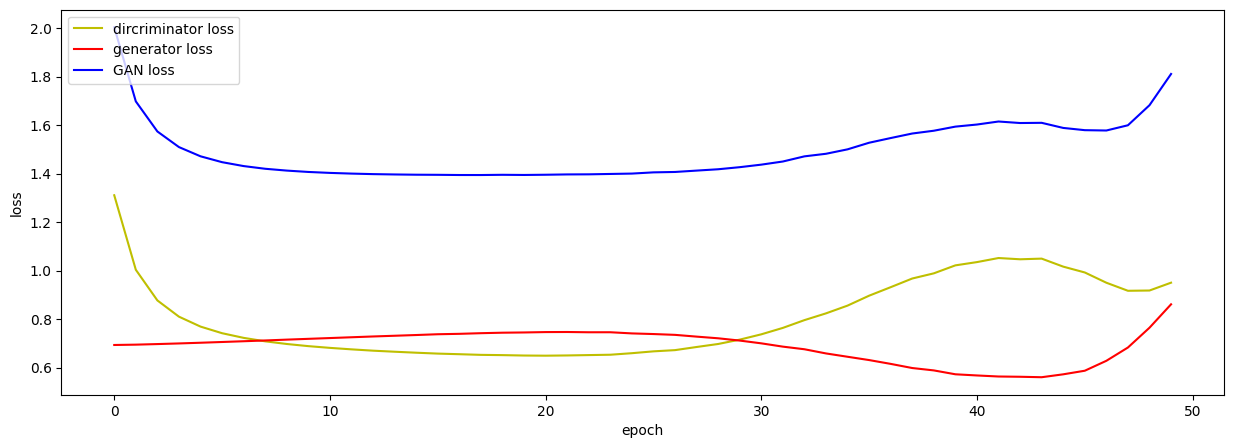

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(loss_D_list, 'y', label = 'dircriminator loss')
loss_ax.plot(loss_G_list, 'r', label = 'generator loss')
loss_ax.plot(loss_GD_list, 'b', label = 'GAN loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
generated_data1 = Generator1(get_noise(batch_size1,latent_dim1))
generated_data2 = Generator2(get_noise(batch_size2,latent_dim2))
generated_data2 =tf.transpose(generated_data2)
#요소별 곱 -> 요소별 합
new_generated_data = generated_data1 * generated_data2
#new_generated_data = generated_data1 + generated_data2

In [ ]:
df_ratings_new = pd.DataFrame(new_generated_data, columns = y_train.columns)
df_ratings_new.index = range(10001, 10001+len(df_ratings_new))
df_ratings_new = df_ratings_new.rename_axis("MovieID")

In [ ]:
df_ratings_new

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
10001,2.059282,2.038499,0.000000,0.353048,2.053779,0.0,0.0,0.0,0.059344,0.0,...,1.396570,0.0,0.135604,2.460016,1.097608,1.876772,2.501239,0.0,0.620882,2.887822
10002,1.340419,1.153743,0.071238,0.209844,1.175900,0.0,0.0,0.0,0.176192,0.0,...,0.710262,0.0,0.043591,1.567589,0.368553,0.822308,1.420321,0.0,0.273690,1.630116
10003,2.583295,2.614659,0.000000,0.416817,3.304379,0.0,0.0,0.0,0.000000,0.0,...,1.574869,0.0,0.299807,3.119053,1.252046,2.330564,2.672278,0.0,0.954420,3.269369
10004,3.286873,2.207474,0.000000,0.063561,2.699002,0.0,0.0,0.0,0.620362,0.0,...,1.349333,0.0,0.080299,2.852660,1.334260,2.177240,2.602467,0.0,0.788911,3.117193
10005,3.323672,2.403415,0.000000,0.352587,2.907479,0.0,0.0,0.0,0.260587,0.0,...,1.589441,0.0,0.061374,3.224448,1.484816,2.393210,2.852985,0.0,0.744189,3.181737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14828,0.563580,0.046831,0.000000,0.000000,0.204465,0.0,0.0,0.0,0.000000,0.0,...,0.031756,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.009580
14829,2.163111,1.544480,0.000000,0.322821,2.306419,0.0,0.0,0.0,0.000000,0.0,...,1.006878,0.0,0.133666,1.833472,0.683516,1.833133,1.883148,0.0,0.718349,2.521543
14830,3.883090,2.631986,0.016889,0.440864,2.953846,0.0,0.0,0.0,0.068888,0.0,...,1.689108,0.0,0.157314,3.299504,1.379902,3.103256,3.200737,0.0,1.281618,4.469738


In [ ]:
max_val = df_ratings_new.max().max()
print(max_val)

12.6507015


In [ ]:
zero_cols = (df_ratings_new == 0).all(axis=0).sum()
print(zero_cols)

687


In [ ]:
df_ratings_new.index.name = 'UserID'
df_ratings_new.columns.name = 'MovieID'
df_ratings_new.name = 'Rating'

In [ ]:
max_val = df_ratings_new.max().max()
print(max_val)

12.6507015


In [ ]:
zero_cols = (df_ratings_new == 0).all(axis=0).sum()
print(zero_cols)

687


<Axes: >

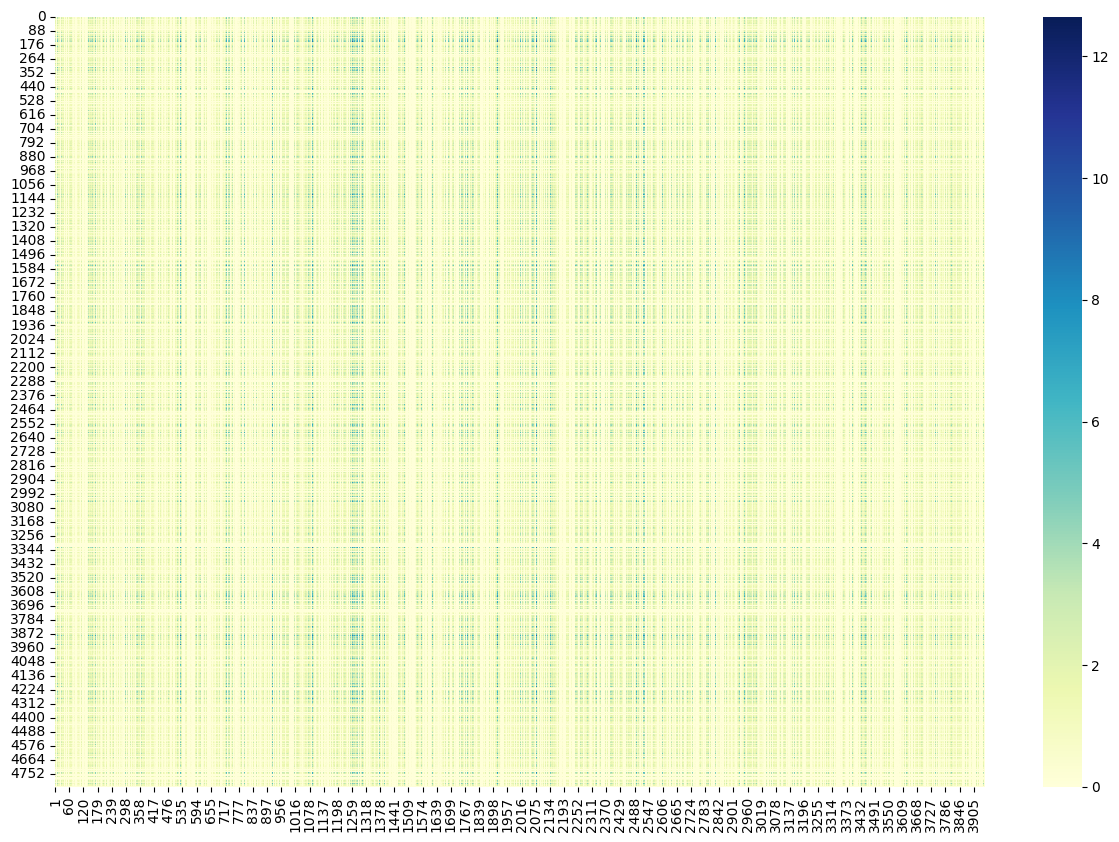

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_ratings_new, cmap='YlGnBu', ax=ax)

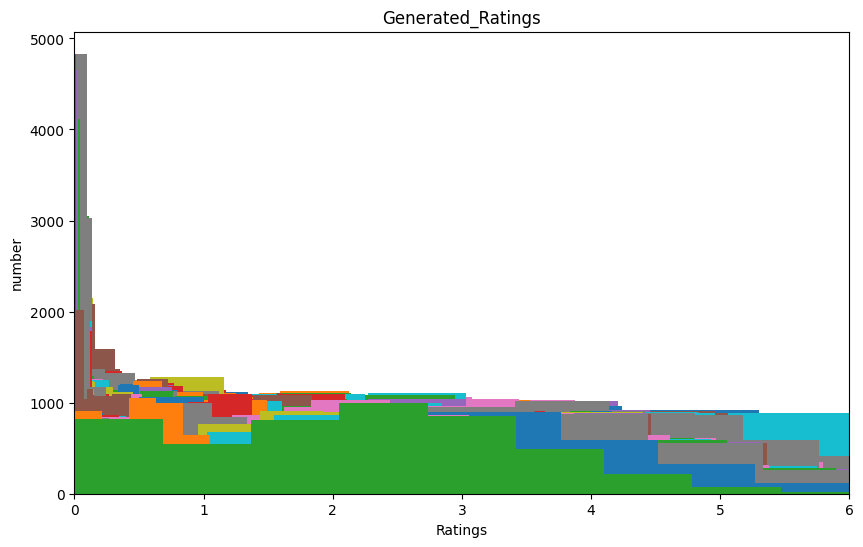

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.figure(figsize=(10, 6))
for column_name in df_ratings_new.columns:
  plt.hist(df_ratings_new[column_name])
plt.xlim(0, 6)
plt.xlabel('Ratings') # x축 라벨 설정
plt.ylabel('number') # y축 라벨 설정
plt.title('Generated_Ratings') # 그래프 제목 설정
plt.show() # 그래프 출력

In [ ]:
#저장_add
df_ratings_new.to_csv(path + 'df_new.csv', index=False)

## binary matrix

In [ ]:
latent_dim1 = 100 # 3883
output_dim1 = 3883
latent_dim2 = 100 # 4832
output_dim2 = 4832

epochs = 50

batch_size1 = 4832
batch_size2 = 3883

lr_d = 0.00006
lr_g = 0.00004


n_iter_D = 1
n_iter_G = 2

In [ ]:
# generator 번갈아 학습

# 생성자 모델
Generator1 = Sequential()
Generator1.add(Dense(128, input_shape=(latent_dim1,), activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())

Generator1.add(Dense(512, activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())
Generator1.add(Dropout(0.3))

Generator1.add(Dense(1024, activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())
Generator1.add(Dropout(0.3))

#output_dim보다 커야함
Generator1.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator1.add(BatchNormalization())

Generator1.add(Dense(output_dim1, activation='relu'))


# 생성자 모델
Generator2 = Sequential()
Generator2.add(Dense(128, input_shape=(latent_dim2,), activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())

Generator2.add(Dense(512, activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())
Generator2.add(Dropout(0.3))

Generator2.add(Dense(1024, activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())
Generator2.add(Dropout(0.3))

#output_dim보다 커야함
Generator2.add(Dense(2048, activation=LeakyReLU(0.2)))
Generator2.add(BatchNormalization())

Generator2.add(Dense(output_dim2, activation='relu'))


# 판별자 모델
Discriminator = Sequential()
Discriminator.add(Dense(2048, input_shape=(output_dim1,), activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())

Discriminator.add(Dense(1024, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(512, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(128, activation=LeakyReLU(0.2)))
Discriminator.add(BatchNormalization())
Discriminator.add(Dropout(0.3))

Discriminator.add(Dense(1, activation='sigmoid'))


Doptimizer = tf.keras.optimizers.Adam(lr_d)
Goptimizer1 = tf.keras.optimizers.Adam(lr_g)
Goptimizer2 = tf.keras.optimizers.Adam(lr_g)


def get_noise(batch_size,latent_dim):
    return tf.random.normal([batch_size,latent_dim])

loss_D_list = []
loss_G_list = []
loss_GD_list = []

for epoch in tf.range(epochs):
    batch_input = X_train.sample(n=batch_size1)

    inputs = tf.Variable(batch_input.values, tf.float32)
    inputs = tf.cast(inputs, tf.float32)

    check_g = True

    #with tf.GradientTape() as t1, tf.GradientTape() as t2:
    with tf.GradientTape(persistent=True) as t1, tf.GradientTape(persistent=True) as t2:

      for iter in range(n_iter_G):
        generated_data1 = Generator1(get_noise(batch_size1,latent_dim1))
        G1 = generated_data1

        generated_data2 = Generator2(get_noise(batch_size2,latent_dim2))
        G2 = generated_data2
        G2 =tf.transpose(G2)

        # 요소별 곱 -> 요소별 합
        G = G1 * G2
        #G = G1 + G2

        Z = Discriminator(G)

        loss_G = -tf.reduce_mean(tf.math.log(Z))

        if check_g == True:
          Ggradients1 = t2.gradient(loss_G,Generator1.trainable_variables)
          #inf 방지??
          Ggradients1 = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients1]
          Goptimizer1.apply_gradients(zip(Ggradients1, Generator1.trainable_variables))
          check_g = False

        else:
          Ggradients2 = t2.gradient(loss_G,Generator2.trainable_variables)
          #inf 방지??
          Ggradients2 = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Ggradients2]
          Goptimizer2.apply_gradients(zip(Ggradients2, Generator2.trainable_variables))
          check_g = True

      for iter in range(n_iter_D):
        generated_data1 = Generator1(get_noise(batch_size1,latent_dim1))
        G1 = generated_data1

        generated_data2 = Generator2(get_noise(batch_size2,latent_dim2))
        G2 = generated_data2
        G2 =tf.transpose(G2)

        # 요소별 곱 -> 요소별 합
        G = G1 * G2
        #G = G1 + G2


        Z = Discriminator(G)

        R = Discriminator(inputs)
        # 둘 다 minimize
        loss_D = -tf.reduce_mean(tf.math.log(R) + tf.math.log(1 - Z))
        #loss_G = -tf.reduce_mean(tf.math.log(Z))
        Dgradients = t1.gradient(loss_D, Discriminator.trainable_variables)
        #inf 방지??
        Dgradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in Dgradients]
        Doptimizer.apply_gradients(zip(Dgradients, Discriminator.trainable_variables))

    loss_D_list.append(loss_D)
    loss_G_list.append(loss_G)
    loss_GD_list.append(loss_D+loss_G)

    del t1
    del t2

    print(f'Epoch: {epoch}, Discriminator Loss: {loss_D}, Generator Loss: {loss_G}, GAN Loss: {loss_D+loss_G}')
    #print(f"epoch: {epoch} d_loss: {loss_D} g_loss: {loss_G}")

Epoch: 0, Discriminator Loss: 1.458749532699585, Generator Loss: 0.6931981444358826, GAN Loss: 2.1519477367401123
Epoch: 1, Discriminator Loss: 1.324004888534546, Generator Loss: 0.6895579099655151, GAN Loss: 2.0135626792907715
Epoch: 2, Discriminator Loss: 1.2253468036651611, Generator Loss: 0.6875731348991394, GAN Loss: 1.9129199981689453
Epoch: 3, Discriminator Loss: 1.1493316888809204, Generator Loss: 0.6858882308006287, GAN Loss: 1.8352198600769043
Epoch: 4, Discriminator Loss: 1.0888117551803589, Generator Loss: 0.68377286195755, GAN Loss: 1.7725846767425537
Epoch: 5, Discriminator Loss: 1.0398436784744263, Generator Loss: 0.6814899444580078, GAN Loss: 1.721333622932434
Epoch: 6, Discriminator Loss: 1.000394344329834, Generator Loss: 0.6779294013977051, GAN Loss: 1.678323745727539
Epoch: 7, Discriminator Loss: 0.9687004089355469, Generator Loss: 0.6734855771064758, GAN Loss: 1.642185926437378
Epoch: 8, Discriminator Loss: 0.9448444247245789, Generator Loss: 0.6674709916114807, GA

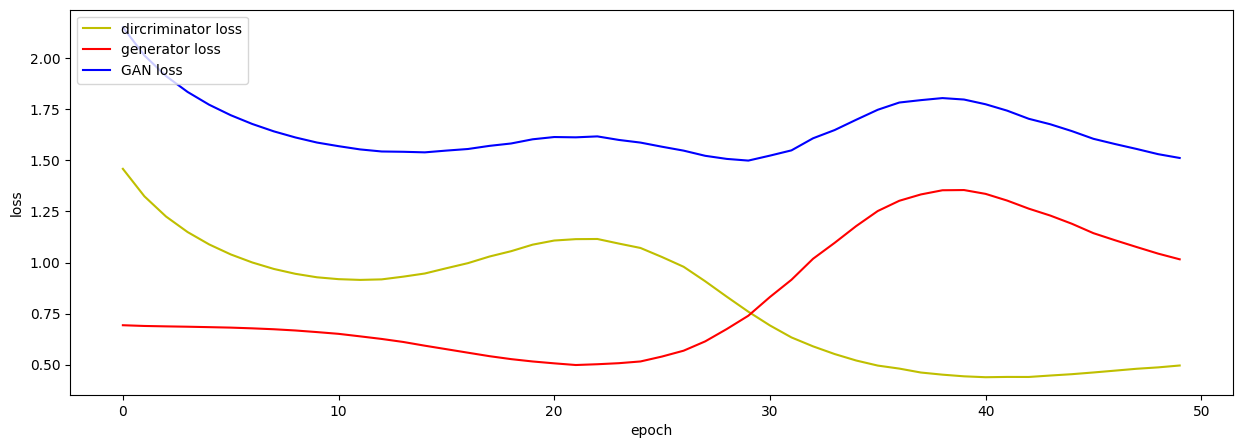

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize = (15,5))

loss_ax.plot(loss_D_list, 'y', label = 'dircriminator loss')
loss_ax.plot(loss_G_list, 'r', label = 'generator loss')
loss_ax.plot(loss_GD_list, 'b', label = 'GAN loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

plt.show()

In [ ]:
generated_data1 = Generator1(get_noise(batch_size1,latent_dim1))
generated_data2 = Generator2(get_noise(batch_size2,latent_dim2))
generated_data2 =tf.transpose(generated_data2)
#요소별 곱 -> 요소별 합
new_generated_data = generated_data1 * generated_data2
#new_generated_data = generated_data1 + generated_data2

In [ ]:
df_ratings_binary = pd.DataFrame(new_generated_data, columns = y_train.columns)
df_ratings_binary.index = range(10001, 10001+len(df_ratings_binary))
df_ratings_binary = df_ratings_binary.rename_axis("MovieID")

In [ ]:
df_ratings_binary

MovieID,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
MovieID,,,,,,,,,,,,,,,,,,,,,
10001,0.191033,0.002224,0.022849,0.057538,0.000000,0.0,0.035309,0.0,0.0,0.000000,...,0.000000,0.000085,0.0,0.0,0.0,0.077996,0.000000,0.0,0.000000,0.0
10002,0.089562,0.026078,0.018445,0.094713,0.000000,0.0,0.050651,0.0,0.0,0.000000,...,0.000000,0.011823,0.0,0.0,0.0,0.052793,0.018958,0.0,0.000000,0.0
10003,0.012394,0.000000,0.031455,0.049314,0.000000,0.0,0.001107,0.0,0.0,0.000412,...,0.000000,0.014639,0.0,0.0,0.0,0.010259,0.000000,0.0,0.000000,0.0
10004,0.052808,0.000000,0.037515,0.053353,0.001023,0.0,0.022099,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.077306,0.000000,0.0,0.000000,0.0
10005,0.000000,0.000000,0.011221,0.019738,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.015836,0.0,0.0,0.0,0.016881,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14828,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
14829,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.003978,0.0,0.0,0.001521,...,0.000137,0.001522,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
14830,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [ ]:
max_val = df_ratings_binary.max().max()
print(max_val)

0.5860797


In [ ]:
zero_cols = (df_ratings_binary == 0).all(axis=0).sum()
print(zero_cols)

124


<Axes: xlabel='MovieID', ylabel='MovieID'>

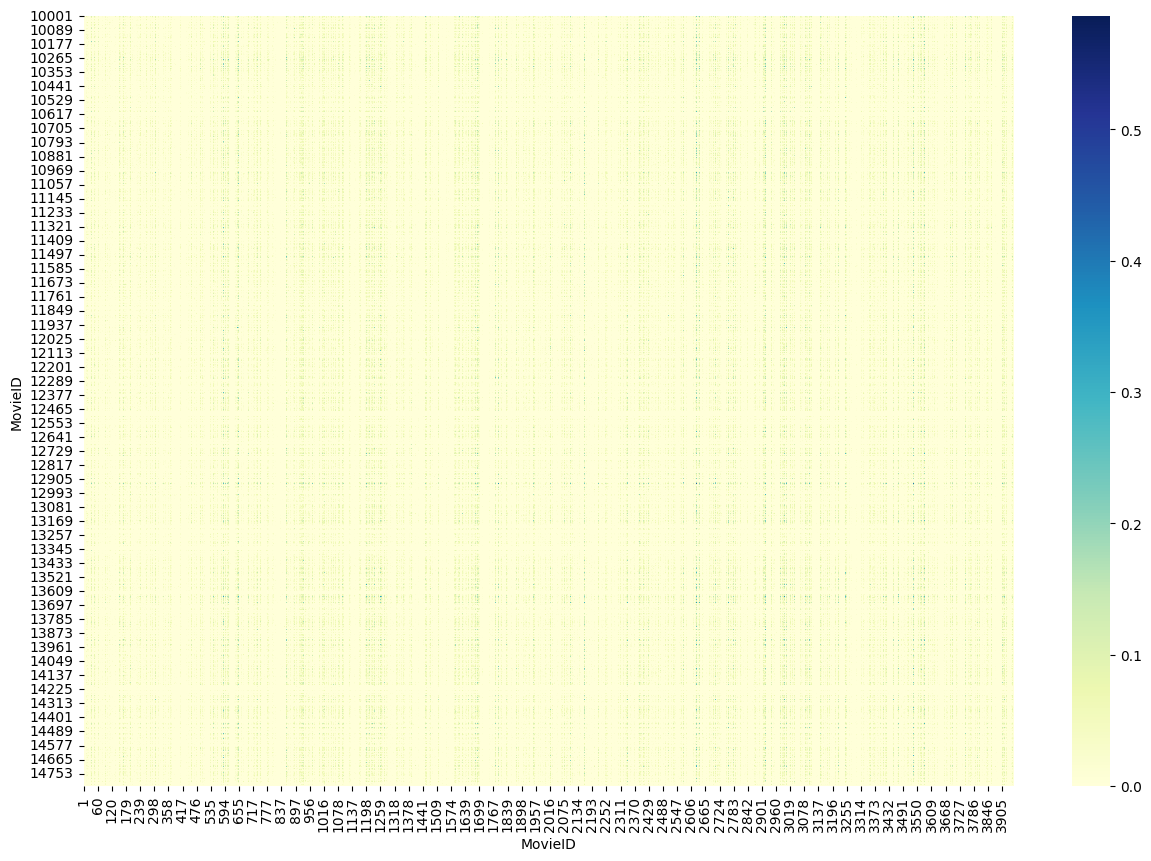

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_ratings_binary, cmap='YlGnBu', ax=ax)

In [ ]:
#저장
df_ratings_binary.to_csv(path + 'df_new_binary.csv', index=False)

## 합치기

In [ ]:
df = pd.read_csv(path + 'df_new.csv')
df_missing = pd.read_csv(path + 'df_new_binary.csv')

missing_df에 ['1':'0'] = [1000209 : 21384031] = [1:21] 비율로 존재

In [ ]:
values_flattened = df_missing.values.flatten()
top_values = sorted(set(values_flattened), reverse=True)[:1500000]

In [ ]:
values_flattened = np.where(np.isin(values_flattened, top_values), 1, 0)

# 1차원 배열을 다시 128 * 3706 크기의 데이터프레임으로 변환
df_missing_final = pd.DataFrame(values_flattened.reshape(4832, 3883), index=df.index, columns=df.columns)

In [ ]:
df_missing_final

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df_final = df_missing_final * df

In [ ]:
df_final = np.ceil(df_final)
df_final[df_final > 5] = 5

In [ ]:
counts = df_final.stack().value_counts()

In [ ]:
counts

0.0    17683961
1.0      617684
2.0      337747
3.0       97014
4.0       21149
5.0        5101
dtype: int64

In [ ]:
df_final = df_final.astype(int)

In [ ]:
df_final

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,0
1,2,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,3,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4827,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4828,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4829,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4830,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Axes: xlabel='MovieID', ylabel='UserID'>

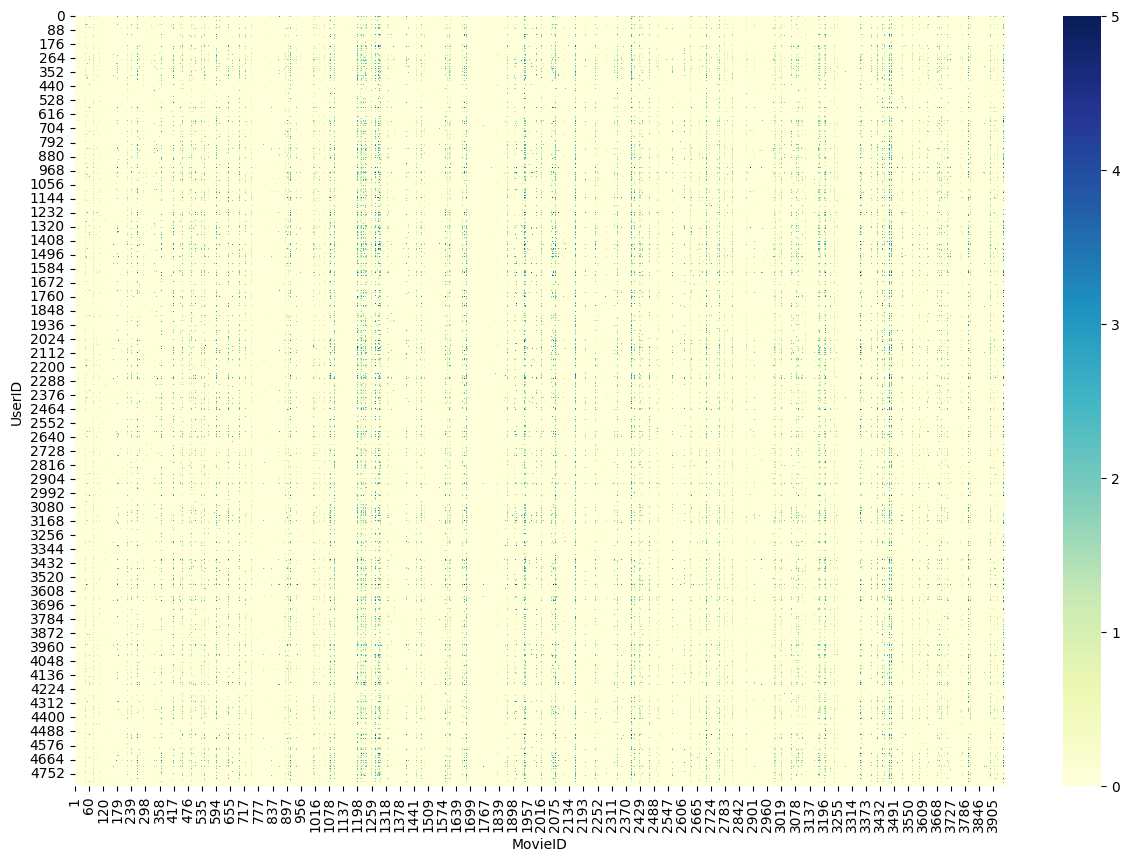

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(df_final, cmap='YlGnBu', ax=ax)

In [ ]:
df_final.index.name = 'UserID'
df_final.columns.name = 'MovieID'
df_final.name = 'Rating'

In [ ]:
df_fake = df_final.reset_index().melt(id_vars='UserID', value_name='Rating', var_name='MovieID').dropna()

In [ ]:
df_fake = df_fake[df_fake['Rating'] != 0]

In [ ]:
df_fake

,UserID,MovieID,Rating
0,0,1,2
1,1,1,2
3,3,1,2
7,7,1,1
9,9,1,2
...,...,...,...
18752611,4451,3950,2
18753962,970,3951,1
18754458,1466,3951,1
18754624,1632,3951,1


In [ ]:
df_fake.to_csv(path + 'df_fake_GAN.csv', index=False)

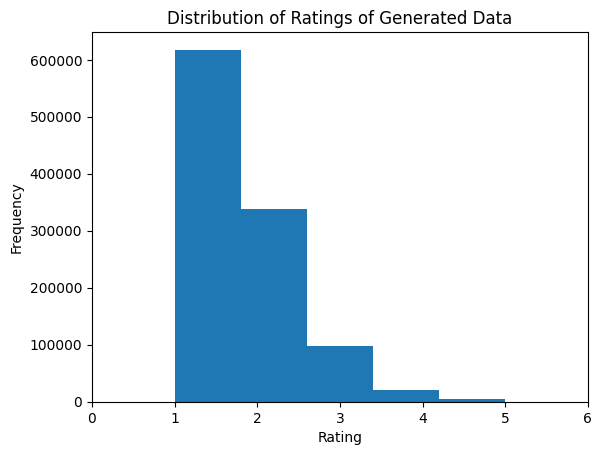

In [ ]:
#df.replace(0, float('nan'), inplace = True)
plt.xlim(0, 6)
colors = ['red', 'green', 'blue', 'orange', 'purple']
plt.hist(df_fake['Rating'], bins = 5)
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings of Generated Data')
plt.show()